In [39]:
import numpy as np
import pandas as pd
import os

data_dir = '/home/martin/projects/hpa_image_analysis/data/distance_matrices'

distance_dict = {}

for file in os.listdir(data_dir):
    dist_list = np.load(os.path.join(data_dir, file)).flatten().tolist()
    gene = file.split('-')[0]
    distance_dict[gene] = dist_list


In [40]:
import matplotlib.pyplot as plt

dist_pdf = []

for val_list in distance_dict.values():
    dist_pdf += val_list


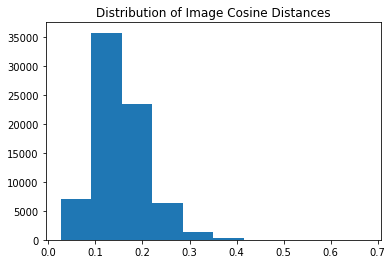

In [41]:
plt.hist(dist_pdf)
plt.title('Distribution of Image Cosine Distances')
plt.show()

In [70]:
np.percentile(dist_pdf, 95)

0.2522292275230832

In [72]:
len([dist for dist in dist_pdf if dist>0.2522292275230832])

3713

In [44]:
len(dist_pdf)

74260

In [45]:
len(distance_dict.keys())

3640

In [73]:
len([dist for dist in distance_dict['A1CF'] if dist>0.2522292275230832])

2

In [74]:
from scipy.stats import hypergeom

gene = 'A1CF'
hypergeom.cdf(len([dist for dist in distance_dict[gene] if dist>0.2522292275230832]), 74260, 3713, len(distance_dict[gene]))

0.9418930292581857

In [75]:
# [gene, total_dist, num_diff_dist, hypergeom_p_val]
from scipy.stats import hypergeom
from tqdm import tqdm_notebook as tqdm

results = []

for gene in tqdm(distance_dict.keys()):
    x = len([dist for dist in distance_dict[gene] if dist>0.2522292275230832])
    N = len(distance_dict[gene])
    pval = hypergeom.sf(x, 74260, 3713, N)
    results.append([gene, N, x, pval])



In [76]:
df = pd.DataFrame(results, columns=['gene', 'total_num_dist', 'num_diff_dist', 'hypergeom_p_val'])
df['fraction_diff_dist'] = df.apply(lambda row: row['num_diff_dist']/row['total_num_dist'], axis=1)
df.head()

,gene,total_num_dist,num_diff_dist,hypergeom_p_val,fraction_diff_dist
0,ATP6V1E1,24,0,0.708068,0.000000
1,ESX1,18,0,0.602829,0.000000
2,CXCR5,33,0,0.816043,0.000000
3,SLC6A1,7,1,0.044373,0.142857
4,GTF2H1,18,0,0.602829,0.000000


In [78]:
df[(df['hypergeom_p_val']<(0.05/3640)) & (df['fraction_diff_dist']>=0.1)].sort_values('hypergeom_p_val')

,gene,total_num_dist,num_diff_dist,hypergeom_p_val,fraction_diff_dist
1230,CASKIN1,4,4,0.000000e+00,1.000000
3540,SLC22A13,2,2,0.000000e+00,1.000000
2159,NUP85,16,13,6.505534e-17,0.812500
566,CA2,21,14,1.210117e-15,0.666667
1290,SH3GL2,22,14,3.625826e-15,0.636364
1300,TUBB,16,11,3.618894e-13,0.687500
103,LCA5L,30,14,2.251209e-12,0.466667
583,PTGES3,18,11,3.359805e-12,0.611111
1117,SLC7A8,22,12,3.887315e-12,0.545455
2129,PBLD,27,13,6.445667e-12,0.481481


In [53]:
colon_df = pd.read_csv('/home/martin/projects/hpa_image_analysis/data/colon_enhanced.csv')
colon_df = colon_df.replace({'Medium':'medium', 'High':'high', 'Not detected':'not detected', 'Low':'low'})
     

In [ ]:
from tqdm import tqdm_notebook as tqdm
stain_list = []
for gene in tqdm(colon_df['gene'].unique()):
    gene_df = colon_df[colon_df['gene']==gene]
    for antibody in gene_df['antibody'].unique():
        antibody_df = gene_df[gene_df['antibody']==antibody]
        stain_list.append([
            gene,
            antibody,
            len(antibody_df[(antibody_df['disease_type']!='colorectal cancer') & (antibody_df['staining']=='low')]),
            len(antibody_df[(antibody_df['disease_type']!='colorectal cancer') & (antibody_df['staining']=='medium')]),
            len(antibody_df[(antibody_df['disease_type']!='colorectal cancer') & (antibody_df['staining']=='high')]),
            len(antibody_df[(antibody_df['disease_type']!='colorectal cancer') & (antibody_df['staining']=='not detected')]),
            len(antibody_df[(antibody_df['disease_type']=='colorectal cancer') & (antibody_df['staining']=='low')]),
            len(antibody_df[(antibody_df['disease_type']=='colorectal cancer') & (antibody_df['staining']=='medium')]),
            len(antibody_df[(antibody_df['disease_type']=='colorectal cancer') & (antibody_df['staining']=='high')]),
            len(antibody_df[(antibody_df['disease_type']=='colorectal cancer') & (antibody_df['staining']=='not detected')]),
        ])
        
        
        

In [80]:
staining_df = pd.DataFrame(stain_list, columns=['gene', 'antibody', 'healthy_low', 'healthy_medium', 'healthy_high', 'health_not_detected',
                                 'cancer_low', 'cancer_medium', 'cancer_high', 'cancer_not_detected'])


In [81]:
df = df.merge(staining_df.groupby('gene').sum(), on=['gene'])

In [82]:
df.to_csv('colon_image_dist_results.csv', index=False)

In [88]:
df.columns

Index(['gene', 'total_num_dist', 'num_diff_dist', 'hypergeom_p_val',
       'fraction_diff_dist', 'healthy_low', 'healthy_medium', 'healthy_high',
       'health_not_detected', 'cancer_low', 'cancer_medium', 'cancer_high',
       'cancer_not_detected'],
      dtype='object')

In [89]:
df['num_healthy_images'] = df.apply(lambda row: row['healthy_low']+row['healthy_medium']+row['healthy_high']+row['health_not_detected'], axis=1)
df['num_cancer_images'] = df.apply(lambda row: row['cancer_low']+row['cancer_medium']+row['cancer_high']+row['cancer_not_detected'], axis=1)
df['cancer_high_fraction'] = df.apply(lambda row: row['cancer_high']/row['num_cancer_images'], axis=1)
df['healthy_high_fraction'] = df.apply(lambda row: row['healthy_high']/row['num_healthy_images'], axis=1)
df['high_staining_diff'] = df.apply(lambda row: row['cancer_high_fraction']-row['healthy_high_fraction'], axis=1)



In [90]:
df.sort_values('hypergeom_p_val').head(100).sort_values('high_staining_diff', ascending=False)

,gene,total_num_dist,num_diff_dist,hypergeom_p_val,fraction_diff_dist,healthy_low,healthy_medium,healthy_high,health_not_detected,cancer_low,cancer_medium,cancer_high,cancer_not_detected,num_healthy_images,num_cancer_images,cancer_high_fraction,healthy_high_fraction,high_staining_diff
1392,CREB3L4,16,7,3.474793e-07,0.437500,0,2,0,0,0,0,8,0,2,8,1.000000,0.000000,1.000000
2242,IKBKB,24,9,9.905188e-08,0.375000,0,3,0,0,4,3,5,1,3,13,0.384615,0.000000,0.384615
381,SLC25A12,14,8,3.079912e-09,0.571429,0,5,0,0,4,7,5,0,5,16,0.312500,0.000000,0.312500
2153,NUP85,16,13,6.505534e-17,0.812500,0,2,0,0,4,2,3,1,2,10,0.300000,0.000000,0.300000
601,TK1,14,6,1.952327e-06,0.428571,0,2,0,0,1,2,2,3,2,8,0.250000,0.000000,0.250000
891,EEF1G,27,10,2.975208e-08,0.370370,0,6,0,0,1,14,5,0,6,20,0.250000,0.000000,0.250000
2417,CCNB1,20,8,1.963445e-07,0.400000,0,7,0,0,9,8,6,2,7,25,0.240000,0.000000,0.240000
82,UQCRC1,14,8,3.079912e-09,0.571429,0,2,5,0,0,3,21,0,7,24,0.875000,0.714286,0.160714
1873,KRT7,10,6,8.156428e-08,0.600000,0,2,0,3,3,4,2,6,5,15,0.133333,0.000000,0.133333
2230,PTTG1,6,4,1.792381e-06,0.666667,2,4,0,0,10,11,3,2,6,26,0.115385,0.000000,0.115385


In [91]:
df.columns

Index(['gene', 'total_num_dist', 'num_diff_dist', 'hypergeom_p_val',
       'fraction_diff_dist', 'healthy_low', 'healthy_medium', 'healthy_high',
       'health_not_detected', 'cancer_low', 'cancer_medium', 'cancer_high',
       'cancer_not_detected', 'num_healthy_images', 'num_cancer_images',
       'cancer_high_fraction', 'healthy_high_fraction', 'high_staining_diff'],
      dtype='object')